In [1]:
# MNI News API - Advanced NLP Analysis Notebook
# Enhanced with spaCy NLP and FinBERT Sentiment Analysis

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from typing import List, Dict, Optional, Tuple
import warnings
from IPython.display import display, HTML
import json

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*80)
print("🚀 MNI News API - Advanced NLP Analysis Notebook")
print("="*80)

# =====================================
# INSTALLATION & SETUP
# =====================================

def setup_dependencies():
    """
    One-time setup for spaCy and FinBERT
    Run this cell first if libraries not installed
    """
    print("📦 Installing dependencies...")
    print("\nRun these commands in your terminal:")
    print("pip install spacy transformers torch")
    print("python -m spacy download en_core_web_sm")
    print("pip install vaderSentiment")
    print("\n✓ Then restart kernel and run notebook")

# =====================================
# AUTHENTICATION
# =====================================

def get_access_token(username: str = None, password: str = None) -> str:
    """Authenticate and get access token"""
    if username is None:
        username = input("Username: ")
    if password is None:
        password = input("Password: ")

    response = requests.post(
        "https://apis.marketnews.com/api/auth/client/token",
        json={"username": username, "password": password},
        headers={"Content-Type": "application/json"}
    )

    if response.status_code != 200:
        raise Exception(f"Login Failed: {response.json()}")

    print("✓ Authentication successful")
    return response.json()["access_token"]

# =====================================
# SPACY NLP ANALYZER
# =====================================

class SpacyNLPAnalyzer:
    """Advanced NLP analysis using spaCy"""

    def __init__(self):
        try:
            import spacy
            self.nlp = spacy.load("en_core_web_sm")
            self.enabled = True
            print("✓ spaCy loaded: en_core_web_sm")
        except:
            self.enabled = False
            print("⚠ spaCy not available. Run setup_dependencies()")

    def analyze_text(self, text: str) -> Dict:
        """Extract entities, keywords, and linguistic features"""
        if not self.enabled:
            return {}

        doc = self.nlp(text)

        # Named Entity Recognition
        entities = {
            'PERSON': [], 'ORG': [], 'GPE': [], 'MONEY': [],
            'PERCENT': [], 'DATE': [], 'CARDINAL': []
        }
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)

        # Key noun phrases
        noun_chunks = [chunk.text for chunk in doc.noun_chunks][:10]

        # Financial keywords detection
        financial_terms = {
            'central_banks': ['fed', 'federal reserve', 'ecb', 'boe', 'fomc'],
            'indicators': ['gdp', 'inflation', 'cpi', 'unemployment', 'pmi'],
            'markets': ['stock', 'bond', 'equity', 'treasury', 'yield'],
            'actions': ['hike', 'cut', 'raise', 'lower', 'tighten', 'ease']
        }

        detected_terms = {}
        text_lower = text.lower()
        for category, terms in financial_terms.items():
            found = [term for term in terms if term in text_lower]
            if found:
                detected_terms[category] = found

        return {
            'entities': entities,
            'noun_phrases': noun_chunks,
            'financial_terms': detected_terms,
            'sentence_count': len(list(doc.sents)),
            'token_count': len(doc)
        }

# =====================================
# FINBERT SENTIMENT ANALYZER
# =====================================

class FinBERTAnalyzer:
    """Financial sentiment using FinBERT transformer model"""

    def __init__(self):
        self.enabled = False
        try:
            from transformers import AutoTokenizer, AutoModelForSequenceClassification
            import torch

            print("📥 Loading FinBERT model (this may take a minute)...")
            model_name = "ProsusAI/finbert"
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(self.device)
            self.model.eval()
            self.enabled = True

            print(f"✓ FinBERT loaded on {self.device}")

        except Exception as e:
            print(f"⚠ FinBERT not available: {e}")
            print("  Install: pip install transformers torch")

    def analyze_sentiment(self, text: str, max_length: int = 512) -> Dict:
        """Analyze financial sentiment using FinBERT"""
        if not self.enabled:
            return {'score': 0.0, 'label': 'NEUTRAL', 'confidence': 0.0}

        import torch

        # Truncate text if too long
        if len(text.split()) > 400:
            text = ' '.join(text.split()[:400])

        inputs = self.tokenizer(text, return_tensors="pt", truncation=True,
                               max_length=max_length, padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # FinBERT labels: [positive, negative, neutral]
        scores = predictions[0].cpu().numpy()
        positive, negative, neutral = scores

        # Convert to -1 to 1 scale
        sentiment_score = positive - negative
        confidence = max(scores)

        if sentiment_score > 0.3:
            label = 'BULLISH'
        elif sentiment_score < -0.3:
            label = 'BEARISH'
        else:
            label = 'NEUTRAL'

        return {
            'score': float(sentiment_score),
            'label': label,
            'confidence': float(confidence),
            'positive_prob': float(positive),
            'negative_prob': float(negative),
            'neutral_prob': float(neutral)
        }

# =====================================
# ENSEMBLE ANALYZER (FinBERT + Rule-based)
# =====================================

class EnsembleAnalyzer:
    """Combine FinBERT with rule-based for robust analysis"""

    def __init__(self):
        self.finbert = FinBERTAnalyzer()
        self.spacy = SpacyNLPAnalyzer()

        # Fallback rule-based
        self.sentiment_rules = {
            'strong_bullish': ['surge', 'soar', 'rally', 'jump', 'spike', 'beat expectations'],
            'bullish': ['rise', 'gain', 'increase', 'improve', 'growth', 'up', 'higher'],
            'strong_bearish': ['plunge', 'crash', 'collapse', 'tumble', 'slump', 'miss expectations'],
            'bearish': ['fall', 'decline', 'drop', 'decrease', 'weak', 'lower', 'down']
        }

    def rule_based_sentiment(self, text: str) -> float:
        """Simple rule-based fallback"""
        text_lower = text.lower()
        score = 0

        for phrase in self.sentiment_rules['strong_bullish']:
            score += text_lower.count(phrase) * 2
        for phrase in self.sentiment_rules['bullish']:
            score += text_lower.count(phrase)
        for phrase in self.sentiment_rules['strong_bearish']:
            score -= text_lower.count(phrase) * 2
        for phrase in self.sentiment_rules['bearish']:
            score -= text_lower.count(phrase)

        return np.tanh(score * 0.3)

    def analyze(self, headline: str, body: str) -> Dict:
        """Complete analysis of article"""
        # Combine headline and body (headline weighted more)
        full_text = f"{headline} {headline} {body}"

        # FinBERT sentiment (primary)
        if self.finbert.enabled:
            sentiment = self.finbert.analyze_sentiment(full_text)
        else:
            # Fallback to rule-based
            score = self.rule_based_sentiment(full_text)
            sentiment = {
                'score': score,
                'label': 'BULLISH' if score > 0.3 else ('BEARISH' if score < -0.3 else 'NEUTRAL'),
                'confidence': min(abs(score) * 1.5, 1.0)
            }

        # spaCy NLP features
        nlp_features = self.spacy.analyze_text(full_text) if self.spacy.enabled else {}

        return {
            **sentiment,
            'nlp_features': nlp_features
        }

# =====================================
# MNI API CLIENT
# =====================================

class MNINewsAPI:
    """MNI News API wrapper"""

    def __init__(self, access_token: str):
        self.base_url = "https://apis.marketnews.com/api/v1/news"
        self.headers = {"Authorization": f"Bearer {access_token}"}

    def get_articles(self, **params) -> Dict:
        """Fetch articles with filters"""
        defaults = {"page": 0, "size": 25}
        params = {**defaults, **params}
        response = requests.get(f"{self.base_url}/articles",
                              headers=self.headers, params=params)
        response.raise_for_status()
        return response.json()

    def get_all_articles_in_timerange(self, start_ms: int, end_ms: int,
                                     page_size: int = 50, **kwargs) -> List[Dict]:
        """Paginate through all articles in timerange"""
        result = []
        page = 0

        print(f"Fetching articles from {datetime.fromtimestamp(start_ms/1000)} "
              f"to {datetime.fromtimestamp(end_ms/1000)}")

        while True:
            response = self.get_articles(
                page=page, size=page_size,
                updatedAfter=start_ms, updatedBefore=end_ms,
                **kwargs
            )
            content = response["content"]
            print(f"  Page {page}: {len(content)} articles")
            result.extend(content)

            if len(content) < page_size:
                break
            page += 1

        print(f"✓ Total fetched: {len(result)}")
        return result

    def search_articles(self, query: str, **params) -> Dict:
        """Search articles"""
        defaults = {"page": 0, "size": 25, "sort": "score"}
        params = {**defaults, **params, "q": query}
        response = requests.get(f"{self.base_url}/search/articles",
                              headers=self.headers, params=params)
        response.raise_for_status()
        return response.json()

    def get_sections(self) -> List[Dict]:
        """Get sections hierarchy"""
        response = requests.get(f"{self.base_url}/sections", headers=self.headers)
        response.raise_for_status()
        return response.json()

    def get_metadata(self, metadata_type: str, page: int = 1, size: int = 100) -> Dict:
        """Get subjects or genres metadata"""
        response = requests.get(
            f"{self.base_url}/metadata/{metadata_type}",
            headers=self.headers,
            params={"page": page, "size": size}
        )
        response.raise_for_status()
        return response.json()

# =====================================
# DATA PROCESSING WITH NLP
# =====================================

def process_articles_with_nlp(articles: any, analyzer: EnsembleAnalyzer = None) -> pd.DataFrame:
    """Convert articles to DataFrame with full NLP analysis"""

    if analyzer is None:
        analyzer = EnsembleAnalyzer()

    # Handle different input types
    if isinstance(articles, dict) and 'content' in articles:
        articles = articles['content']
    elif not isinstance(articles, list):
        articles = [articles]

    print(f"Processing {len(articles)} articles with NLP analysis...")

    data = []
    for idx, article in enumerate(articles):
        if len(articles) > 50 and (idx + 1) % 50 == 0:
            print(f"  {idx + 1}/{len(articles)} processed...")

        headline = article.get('headline', '')
        body = article.get('body_text', '')

        # Full analysis
        analysis = analyzer.analyze(headline, body)

        # Extract subjects and genres
        subjects = article.get('subject', [])
        genres = article.get('genre', [])

        # Extract NLP entities
        entities = analysis.get('nlp_features', {}).get('entities', {})

        data.append({
            'uri': article.get('uri', ''),
            'headline': headline,
            'body_text': body,
            'versioncreated': article.get('versioncreated', ''),
            'subjects': ', '.join([s.get('name', '') for s in subjects]),
            'genres': ', '.join([g.get('name', '') for g in genres]),

            # Sentiment
            'sentiment_score': analysis['score'],
            'sentiment_label': analysis['label'],
            'sentiment_confidence': analysis.get('confidence', 0),

            # NLP Features
            'organizations': ', '.join(entities.get('ORG', [])[:5]),
            'locations': ', '.join(entities.get('GPE', [])[:5]),
            'people': ', '.join(entities.get('PERSON', [])[:3]),
            'money_mentions': ', '.join(entities.get('MONEY', [])[:3]),
            'percent_mentions': ', '.join(entities.get('PERCENT', [])[:3]),

            # Financial terms
            'financial_terms': str(analysis.get('nlp_features', {}).get('financial_terms', {})),

            # Stats
            'word_count': len(body.split()),
            'sentence_count': analysis.get('nlp_features', {}).get('sentence_count', 0)
        })

    df = pd.DataFrame(data)

    # Parse timestamps
    if len(df) > 0 and 'versioncreated' in df.columns:
        df['versioncreated'] = pd.to_datetime(df['versioncreated'])
        df['date'] = df['versioncreated'].dt.date
        df['hour'] = df['versioncreated'].dt.hour
        df['day_of_week'] = df['versioncreated'].dt.day_name()
        df['time_of_day'] = pd.cut(df['hour'],
                                    bins=[0, 6, 12, 18, 24],
                                    labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    print(f"✓ Completed: {len(articles)} articles processed")
    return df

# =====================================
# EQUITY RELEVANCE ANALYZER
# =====================================

class EquityRelevanceAnalyzer:
    """Determine equity market relevance and impact"""

    def __init__(self):
        self.equity_keywords = {
            'direct': ['s&p 500', 'spx', 'nasdaq', 'dow jones', 'stock market',
                      'stocks', 'equities', 'wall street'],
            'sectors': ['tech stocks', 'bank stocks', 'financials', 'energy stocks'],
            'indicators': ['gdp', 'nonfarm payrolls', 'unemployment', 'cpi',
                          'inflation', 'retail sales', 'consumer confidence'],
            'fed': ['federal reserve', 'fed', 'fomc', 'interest rate', 'monetary policy']
        }

        self.sector_map = {
            'Technology': ['tech', 'semiconductor', 'software', 'ai', 'cloud'],
            'Financials': ['bank', 'financial', 'lending', 'credit'],
            'Energy': ['oil', 'energy', 'crude', 'natural gas'],
            'Healthcare': ['healthcare', 'pharma', 'biotech', 'drug'],
            'Consumer': ['retail', 'consumer', 'spending'],
            'Industrials': ['manufacturing', 'industrial', 'transport']
        }

    def analyze(self, row: pd.Series) -> Dict:
        """Analyze equity relevance of article"""
        text = (row['headline'] + ' ' + row['body_text']).lower()
        headline = row['headline'].lower()

        score = 0
        reasons = []
        sectors = []

        # Direct equity mentions (40 points)
        if any(kw in text for kw in self.equity_keywords['direct']):
            score += 40
            reasons.append("Direct equity mention")

        # Economic indicators (30 points)
        if any(kw in text for kw in self.equity_keywords['indicators']):
            score += 30
            reasons.append("Economic indicator")

        # Fed/central bank (25 points)
        if any(kw in text for kw in self.equity_keywords['fed']):
            score += 25
            reasons.append("Central bank policy")

        # Identify affected sectors
        for sector, keywords in self.sector_map.items():
            if any(kw in text for kw in keywords):
                sectors.append(sector)

        score = min(score, 100)
        is_relevant = score >= 40

        # Market impact
        sentiment = row.get('sentiment_score', 0)
        if sentiment > 0.3:
            impact = 'BULLISH'
        elif sentiment < -0.3:
            impact = 'BEARISH'
        else:
            impact = 'NEUTRAL'

        # Hawkish/Dovish override
        if any(word in text for word in ['hawkish', 'rate hike', 'tightening']):
            impact = 'BEARISH'
        if any(word in text for word in ['dovish', 'rate cut', 'easing']):
            impact = 'BULLISH'

        return {
            'is_equity_relevant': is_relevant,
            'equity_score': score,
            'equity_impact': impact,
            'equity_reasons': '; '.join(reasons) if reasons else 'N/A',
            'affected_sectors': ', '.join(sectors) if sectors else 'Broad Market',
            'urgency': 'HIGH' if score >= 70 else ('MEDIUM' if score >= 50 else 'LOW')
        }

def add_equity_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """Add equity relevance columns to dataframe"""
    if df.empty:
        return df

    print(f"Analyzing equity relevance for {len(df)} articles...")

    analyzer = EquityRelevanceAnalyzer()
    results = [analyzer.analyze(row) for _, row in df.iterrows()]

    equity_df = pd.DataFrame(results)
    result = pd.concat([df.reset_index(drop=True), equity_df], axis=1)

    relevant = result['is_equity_relevant'].sum()
    print(f"✓ {relevant} equity-relevant articles ({relevant/len(result)*100:.1f}%)")

    return result

# =====================================
# VISUALIZATION FUNCTIONS
# =====================================

def plot_sentiment_timeline(df: pd.DataFrame):
    """Plot sentiment over time"""
    if df.empty or 'versioncreated' not in df.columns:
        print("No data to plot")
        return

    df = df.sort_values('versioncreated')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    # Sentiment scatter
    colors = df['sentiment_label'].map({'BULLISH': 'green', 'BEARISH': 'red', 'NEUTRAL': 'gray'})
    ax1.scatter(df['versioncreated'], df['sentiment_score'],
               c=colors, alpha=0.6, s=100)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Sentiment Score', fontsize=12)
    ax1.set_title('Article Sentiment Timeline', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Rolling average
    if len(df) > 10:
        df_sorted = df.set_index('versioncreated').sort_index()
        rolling = df_sorted['sentiment_score'].rolling(window=10, min_periods=1).mean()
        ax2.plot(rolling.index, rolling.values, color='blue', linewidth=2)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax2.fill_between(rolling.index, rolling.values, 0,
                         where=(rolling.values >= 0), alpha=0.3, color='green')
        ax2.fill_between(rolling.index, rolling.values, 0,
                         where=(rolling.values < 0), alpha=0.3, color='red')
        ax2.set_ylabel('Rolling Avg (10 articles)', fontsize=12)
        ax2.set_title('Sentiment Moving Average', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_entity_analysis(df: pd.DataFrame, entity_col: str = 'organizations', top_n: int = 15):
    """Plot most mentioned entities"""
    if df.empty or entity_col not in df.columns:
        print(f"No {entity_col} data")
        return

    # Extract all entities
    all_entities = []
    for entities_str in df[entity_col].dropna():
        if entities_str:
            all_entities.extend([e.strip() for e in entities_str.split(',')])

    if not all_entities:
        print(f"No {entity_col} found")
        return

    # Count and plot
    counts = Counter(all_entities).most_common(top_n)
    entities, freqs = zip(*counts)

    plt.figure(figsize=(14, 8))
    plt.barh(range(len(entities)), freqs, color='steelblue')
    plt.yticks(range(len(entities)), entities)
    plt.xlabel('Mentions', fontsize=12)
    plt.title(f'Top {top_n} {entity_col.title()}', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_equity_dashboard(df: pd.DataFrame):
    """Comprehensive equity impact dashboard"""
    equity_df = df[df['is_equity_relevant']].copy()

    if equity_df.empty:
        print("No equity-relevant news")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Impact distribution
    impact_counts = equity_df['equity_impact'].value_counts()
    colors = {'BULLISH': 'green', 'BEARISH': 'red', 'NEUTRAL': 'gray'}
    ax1.bar(impact_counts.index, impact_counts.values,
           color=[colors[x] for x in impact_counts.index])
    ax1.set_title('Market Impact Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Count')

    # 2. Relevance score distribution
    ax2.hist(equity_df['equity_score'], bins=20, color='steelblue', edgecolor='black')
    ax2.set_title('Equity Relevance Score Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Relevance Score')
    ax2.set_ylabel('Count')

    # 3. Sentiment by impact
    for impact in ['BULLISH', 'BEARISH', 'NEUTRAL']:
        mask = equity_df['equity_impact'] == impact
        if mask.any():
            ax3.scatter(equity_df[mask].index, equity_df[mask]['sentiment_score'],
                       label=impact, alpha=0.6, s=100, c=colors[impact])
    ax3.set_title('Sentiment Score by Impact', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Sentiment Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Urgency breakdown
    urgency_counts = equity_df['urgency'].value_counts()
    ax4.pie(urgency_counts.values, labels=urgency_counts.index, autopct='%1.1f%%',
           colors=['red', 'orange', 'yellow'])
    ax4.set_title('Signal Urgency Breakdown', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def display_top_signals(df: pd.DataFrame, top_n: int = 15):
    """Display actionable equity signals"""
    equity_df = df[df['is_equity_relevant']].copy()

    if equity_df.empty:
        print("No equity-relevant news")
        return

    # Sort by urgency and score
    urgency_map = {'HIGH': 0, 'MEDIUM': 1, 'LOW': 2}
    equity_df['urgency_rank'] = equity_df['urgency'].map(urgency_map)
    equity_df = equity_df.sort_values(['urgency_rank', 'equity_score'], ascending=[True, False])

    print("\n" + "="*100)
    print("🎯 TOP EQUITY TRADING SIGNALS")
    print("="*100 + "\n")

    for idx, row in equity_df.head(top_n).iterrows():
        impact_emoji = "📈" if row['equity_impact'] == 'BULLISH' else ("📉" if row['equity_impact'] == 'BEARISH' else "➡️")
        urgency_dots = "🔴" * (3 if row['urgency'] == 'HIGH' else (2 if row['urgency'] == 'MEDIUM' else 1))

        print(f"{impact_emoji} {row['headline']}")
        print(f"   Time: {row['versioncreated'].strftime('%Y-%m-%d %H:%M')}")
        print(f"   Impact: {row['equity_impact']} | Relevance: {row['equity_score']:.0f}/100")
        print(f"   Sentiment: {row['sentiment_score']:+.2f} ({row['sentiment_confidence']:.0%} confidence)")
        print(f"   Urgency: {urgency_dots} {row['urgency']}")
        print(f"   Sectors: {row['affected_sectors']}")

        if row['organizations']:
            print(f"   Organizations: {row['organizations']}")

        print()

def generate_summary_report(df: pd.DataFrame):
    """Generate executive summary"""
    print("\n" + "="*80)
    print("📊 EXECUTIVE SUMMARY")
    print("="*80 + "\n")

    print(f"Total Articles Analyzed: {len(df)}")
    print(f"Date Range: {df['versioncreated'].min()} to {df['versioncreated'].max()}")

    print(f"\n📈 Sentiment Analysis:")
    print(f"   Average Sentiment: {df['sentiment_score'].mean():+.3f}")
    print(f"   Bullish: {(df['sentiment_label']=='BULLISH').sum()} ({(df['sentiment_label']=='BULLISH').sum()/len(df)*100:.1f}%)")
    print(f"   Bearish: {(df['sentiment_label']=='BEARISH').sum()} ({(df['sentiment_label']=='BEARISH').sum()/len(df)*100:.1f}%)")
    print(f"   Neutral: {(df['sentiment_label']=='NEUTRAL').sum()} ({(df['sentiment_label']=='NEUTRAL').sum()/len(df)*100:.1f}%)")

    if 'is_equity_relevant' in df.columns:
        equity = df[df['is_equity_relevant']]
        print(f"\n💹 Equity Market Impact:")
        print(f"   Equity-Relevant Articles: {len(equity)} ({len(equity)/len(df)*100:.1f}%)")
        print(f"   Average Equity Score: {equity['equity_score'].mean():.1f}/100")
        print(f"   High Priority Signals: {(equity['urgency']=='HIGH').sum()}")

    # Top organizations
    all_orgs = []
    for orgs in df['organizations'].dropna():
        if orgs:
            all_orgs.extend([o.strip() for o in orgs.split(',')])

    if all_orgs:
        top_orgs = Counter(all_orgs).most_common(5)
        print(f"\n🏢 Most Mentioned Organizations:")
        for org, count in top_orgs:
            print(f"   {org}: {count} mentions")

    print("\n" + "="*80 + "\n")

# =====================================
# UTILITY FUNCTIONS
# =====================================

def days_ago(days: int) -> int:
    """Unix timestamp for N days ago (milliseconds)"""
    return int((datetime.now() - timedelta(days=days)).timestamp() * 1000)

def timestamp_now() -> int:
    """Current Unix timestamp (milliseconds)"""
    return int(datetime.now().timestamp() * 1000)

# =====================================
# EXAMPLE USAGE
# =====================================

"""
# Complete Workflow Example:

# 1. Authenticate
access_token = get_access_token()
api = MNINewsAPI(access_token)

# 2. Initialize analyzer
analyzer = EnsembleAnalyzer()

# 3. Fetch articles (last 7 days)
articles = api.get_all_articles_in_timerange(
    start_ms=days_ago(7),
    end_ms=timestamp_now(),
    page_size=50
)

# 4. Process with NLP
df = process_articles_with_nlp(articles, analyzer)

# 5. Add equity analysis
df = add_equity_analysis(df)

# 6. Generate insights
generate_summary_report(df)
display_top_signals(df, top_n=15)

# 7. Visualizations
plot_sentiment_timeline(df)
plot_entity_analysis(df, 'organizations', top_n=15)
plot_equity_dashboard(df)

# 8. Filter and export
high_priority = df[
    (df['is_equity_relevant']) &
    (df['urgency'] == 'HIGH') &
    (df['sentiment_confidence'] > 0.7)
]

df.to_csv('mni_full_analysis.csv', index=False)
high_priority.to_csv('mni_priority_signals.csv', index=False)

print(f"✓ Exported {len(high_priority)} priority signals")
"""

print("\n✅ Notebook Ready!")
print("\nAvailable Functions:")
print("   🔐 get_access_token() - Authenticate")
print("   📡 MNINewsAPI() - API client")
print("   🤖 EnsembleAnalyzer() - FinBERT + spaCy analyzer")
print("   📊 process_articles_with_nlp() - Full NLP processing")
print("   💹 add_equity_analysis() - Equity relevance")
print("   📈 plot_sentiment_timeline() - Visualizations")
print("   🎯 display_top_signals() - Trading signals")
print("   📋 generate_summary_report() - Executive summary")
print("\n" + "="*80)

🚀 MNI News API - Advanced NLP Analysis Notebook

✅ Notebook Ready!

Available Functions:
   🔐 get_access_token() - Authenticate
   📡 MNINewsAPI() - API client
   🤖 EnsembleAnalyzer() - FinBERT + spaCy analyzer
   📊 process_articles_with_nlp() - Full NLP processing
   💹 add_equity_analysis() - Equity relevance
   📈 plot_sentiment_timeline() - Visualizations
   🎯 display_top_signals() - Trading signals
   📋 generate_summary_report() - Executive summary



In [4]:
# from mni_news_notebook import get_access_token, MNINewsAPI
# from mni_news_notebook import articles_to_dataframe, add_equity_analysis

username = "rbceurope01"
password = "k8NibeSdYKU4F5N"

access_token = get_access_token(username, password)
api = MNINewsAPI(access_token)

✓ Authentication successful


In [9]:
analyzer = EnsembleAnalyzer()

📥 Loading FinBERT model (this may take a minute)...
✓ FinBERT loaded on cpu
✓ spaCy loaded: en_core_web_sm


In [8]:
articles = api.get_all_articles_in_timerange(
    start_ms=days_ago(7),
    end_ms=timestamp_now(),
    page_size=50
)

Fetching articles from 2025-10-13 21:27:08.058000 to 2025-10-20 21:27:08.058000
  Page 0: 50 articles
  Page 1: 50 articles
  Page 2: 50 articles
  Page 3: 50 articles
  Page 4: 50 articles
  Page 5: 50 articles
  Page 6: 50 articles
  Page 7: 50 articles
  Page 8: 50 articles
  Page 9: 50 articles
  Page 10: 50 articles
  Page 11: 50 articles
  Page 12: 50 articles
  Page 13: 50 articles
  Page 14: 50 articles
  Page 15: 50 articles
  Page 16: 50 articles
  Page 17: 50 articles
  Page 18: 50 articles
  Page 19: 50 articles
  Page 20: 50 articles
  Page 21: 50 articles
  Page 22: 50 articles
  Page 23: 50 articles
  Page 24: 50 articles
  Page 25: 50 articles
  Page 26: 50 articles
  Page 27: 50 articles
  Page 28: 50 articles
  Page 29: 50 articles
  Page 30: 50 articles
  Page 31: 50 articles
  Page 32: 50 articles
  Page 33: 50 articles
  Page 34: 50 articles
  Page 35: 50 articles
  Page 36: 50 articles
  Page 37: 50 articles
  Page 38: 50 articles
  Page 39: 50 articles
  Page 40:

Processing 2685 articles with NLP analysis...
  50/2685 processed...
  100/2685 processed...
  150/2685 processed...
  200/2685 processed...
  250/2685 processed...
  300/2685 processed...
  350/2685 processed...
  400/2685 processed...
  450/2685 processed...
  500/2685 processed...
  550/2685 processed...
  600/2685 processed...
  650/2685 processed...
  700/2685 processed...
  750/2685 processed...
  800/2685 processed...
  850/2685 processed...
  900/2685 processed...
  950/2685 processed...
  1000/2685 processed...
  1050/2685 processed...
  1100/2685 processed...
  1150/2685 processed...
  1200/2685 processed...
  1250/2685 processed...
  1300/2685 processed...
  1350/2685 processed...
  1400/2685 processed...
  1450/2685 processed...
  1500/2685 processed...
  1550/2685 processed...
  1600/2685 processed...
  1650/2685 processed...
  1700/2685 processed...
  1750/2685 processed...
  1800/2685 processed...
  1850/2685 processed...
  1900/2685 processed...
  1950/2685 processed...

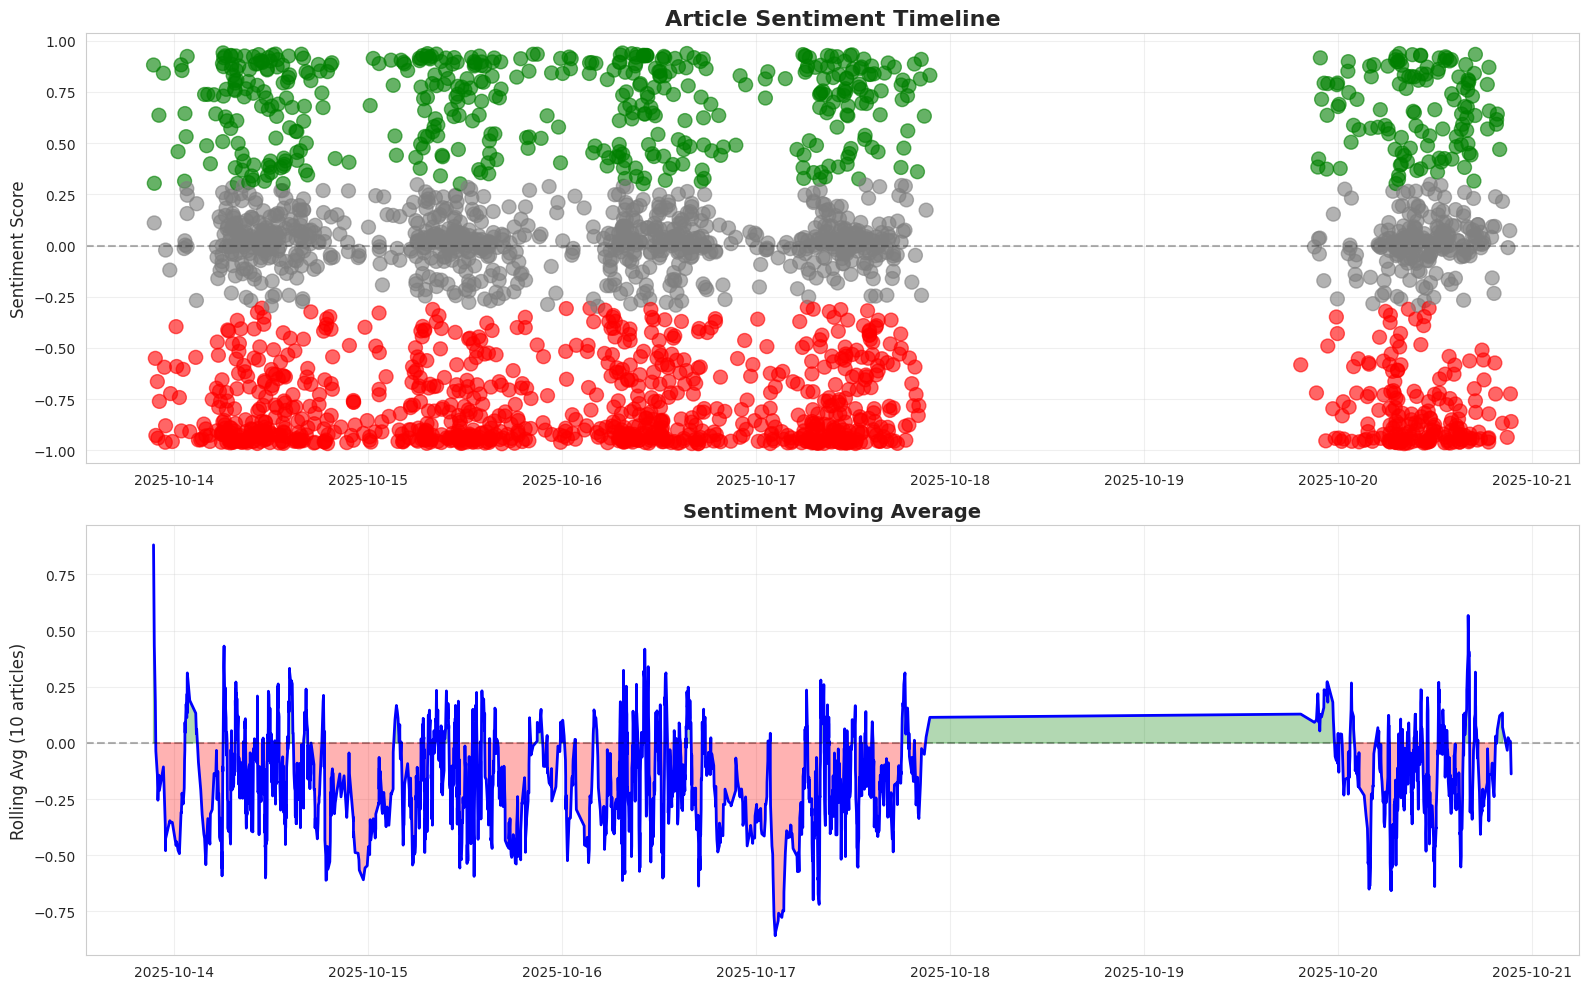

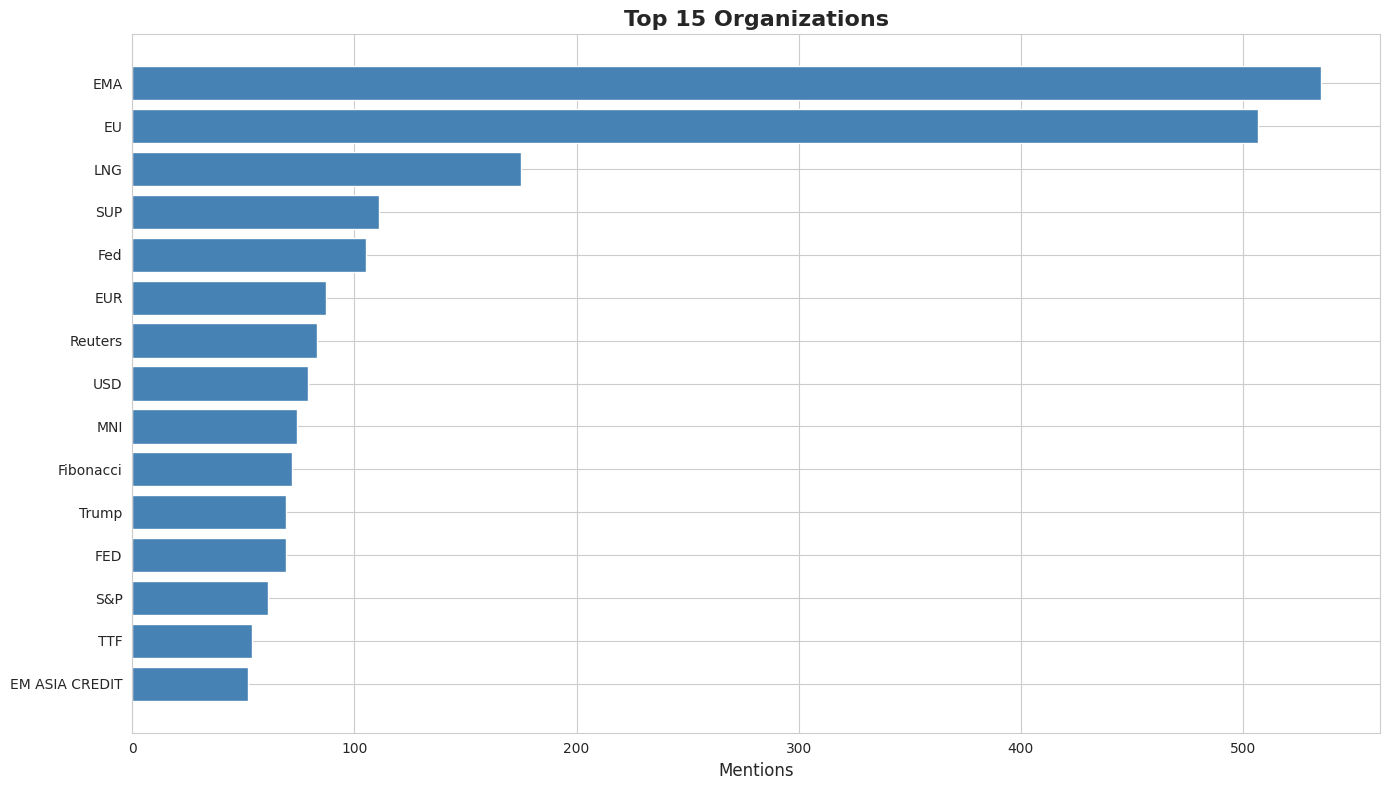

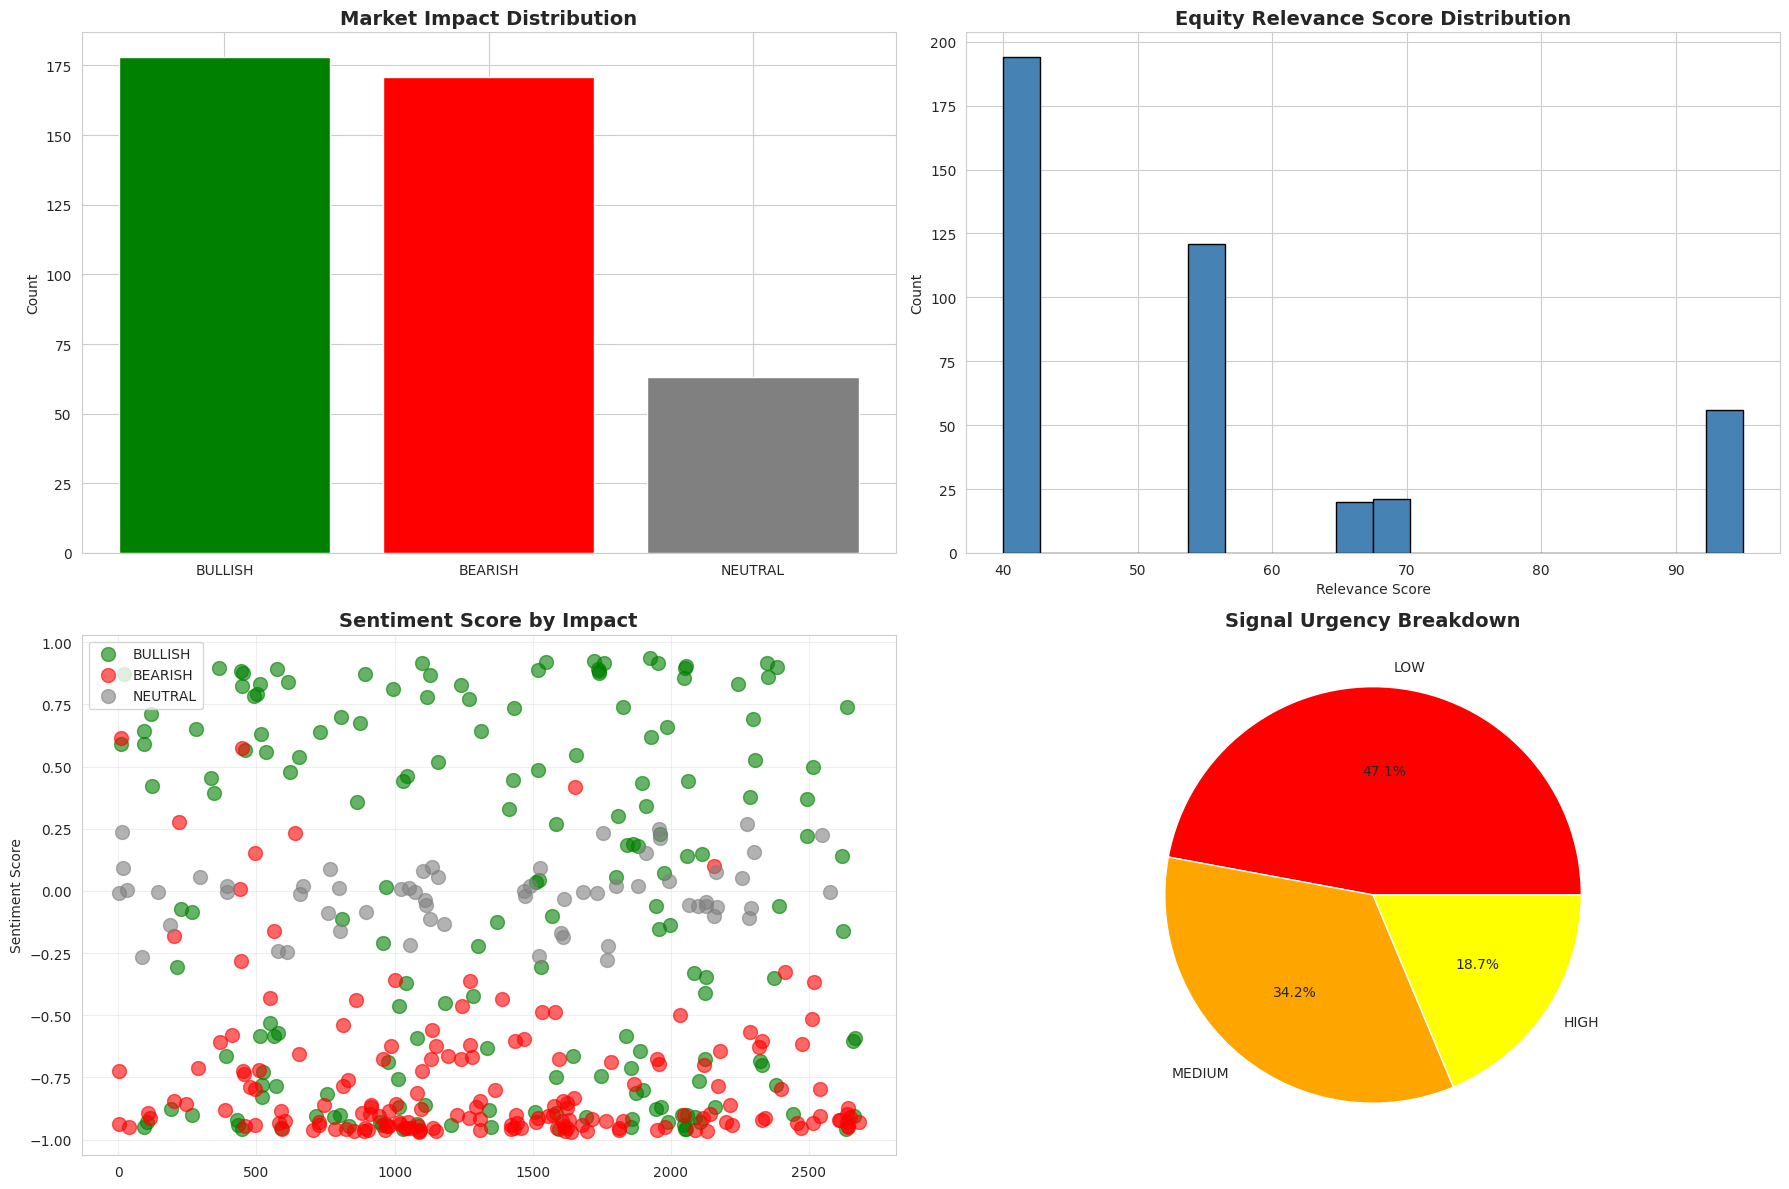

In [10]:
# 4. Process with NLP
df = process_articles_with_nlp(articles, analyzer)

# 5. Add equity analysis
df = add_equity_analysis(df)

# 6. Generate insights
generate_summary_report(df)
display_top_signals(df, top_n=15)

# 7. Visualizations
plot_sentiment_timeline(df)
plot_entity_analysis(df, 'organizations', top_n=15)
plot_equity_dashboard(df)

# 8. Filter and export
high_priority = df[
    (df['is_equity_relevant']) &
    (df['urgency'] == 'HIGH') &
    (df['sentiment_confidence'] > 0.7)
]


In [7]:
process_articles_with_nlp()

TypeError: process_articles_with_nlp() missing 1 required positional argument: 'articles'

In [ ]:
add_equity_analysis()

In [ ]:
plot_sentiment_timeline()

In [ ]:
display_top_signals()

In [ ]:
generate_summary_report()

In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.3 MB/s eta 0:00:00


In [3]:
!pip install spacy transformers torch
